# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
# Memuat dataset
url = 'https://raw.githubusercontent.com/Fadelhamkaa/Belajar-Machine-Learning-untuk-Pemula/main/Dataset_inisiasi.csv'
# Pastikan path file sudah sesuai
df = pd.read_csv(url)

# Simpan dataset asli untuk referensi jika diperlukan
df_original = df.copy()

#Tampilkan isi dataset
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Age_Category,Work_Experience_Category,Family_Size_Category,Cluster,Cluster_After_FeatureSelection,temp_label,Cluster_After_PCA
0,-0.258250,Male,No,-1.284623,No,Healthcare,-5.087633e-01,Low,0.767001,Cat_4,Young,Low,Medium,1,1,0,2
1,-0.322213,Female,Yes,-0.327151,Yes,Engineer,7.045540e-17,Average,0.099972,Cat_4,Adult,Moderate,Medium,0,0,0,2
2,1.092695,Female,Yes,1.408268,Yes,Engineer,-5.087633e-01,Low,-1.234085,Cat_6,Mature,Low,Small,2,2,1,0
3,-0.672087,Male,Yes,1.408268,Yes,Lawyer,-8.186706e-01,High,-0.567056,Cat_6,Mature,Low,Small,2,2,1,0
4,-0.312195,Female,Yes,-0.207467,Yes,Entertainment,7.045540e-17,High,2.101059,Cat_6,Adult,Moderate,Very Large,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7715,0.207607,Male,No,-1.284623,No,Artist,-8.186706e-01,Low,2.768088,Cat_1,Young,Low,Very Large,1,1,0,2
7716,0.464618,Male,No,-0.506677,No,Executive,1.110512e-01,Low,0.767001,Cat_4,Young,Moderate,Medium,1,1,0,2
7717,0.742436,Female,No,-0.626361,Yes,Healthcare,-5.087633e-01,Low,-1.234085,Cat_6,Young,Low,Small,0,0,1,0
7718,1.471854,Female,No,-0.985413,Yes,Healthcare,-5.087633e-01,Low,0.767001,Cat_6,Young,Low,Medium,1,1,0,2


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [3]:
# Tentukan nama kolom target yang akan diprediksi
target_column = "Cluster_After_FeatureSelection"

# Tentukan kolom-kolom yang akan di-drop dari fitur, misalnya kolom ID dan label asli
drop_columns = ["Unique ID", "Indicator ID", "cluster_label", target_column]

# Pastikan hanya menghapus kolom yang memang ada di dataset
existing_drop_columns = [col for col in drop_columns if col in df.columns]

# Memisahkan variabel independen (fitur) dan dependen (label target)
X = df.drop(columns=existing_drop_columns)
y = df[target_column]

# Melakukan pembagian dataset menjadi data latih (80%) dan data uji (20%) dengan stratifikasi berdasarkan target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Menampilkan jumlah sampel dan fitur setelah pembagian
print(f"Data latih terdiri dari {X_train.shape[0]} sampel dan {X_train.shape[1]} fitur.")
print(f"Data uji terdiri dari {X_test.shape[0]} sampel dan {X_test.shape[1]} fitur.")

Data latih terdiri dari 6176 sampel dan 16 fitur.
Data uji terdiri dari 1544 sampel dan 16 fitur.


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [4]:
# ===  Menentukan Preprocessing ===
# Menentukan kolom-kolom kategorikal (tipe object)
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Untuk model SVM, kita juga butuh mengidentifikasi kolom numerik untuk dinormalisasi
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing untuk model berbasis pohon (Decision Tree dan Random Forest)
tree_preprocessor = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessing untuk model SVM (dengan normalisasi tambahan untuk fitur numerik)
svm_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), numerical_cols)
    ]
)

# Membangun Model Klasifikasi
# Model Decision Tree
decision_tree_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5))
])
decision_tree_pipeline.fit(X_train, y_train)
dt_predictions = decision_tree_pipeline.predict(X_test)

# Model Random Forest
random_forest_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", RandomForestClassifier(random_state=21, n_estimators=100))
])
random_forest_pipeline.fit(X_train, y_train)
rf_predictions = random_forest_pipeline.predict(X_test)

# Model SVM
svm_pipeline = Pipeline([
    ("preprocessing", svm_preprocessor),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
])
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Evaluasi Model
print("\nEvaluasi Decision Tree:")
print(pd.DataFrame(classification_report(y_test, dt_predictions, output_dict=True)).T)

print("\nEvaluasi Random Forest:")
print(pd.DataFrame(classification_report(y_test, rf_predictions, output_dict=True)).T)

print("\nEvaluasi SVM:")
print(pd.DataFrame(classification_report(y_test, svm_predictions, output_dict=True)).T)

# Menampilkan akurasi keseluruhan untuk setiap model
print("\nAkurasi Decision Tree:", accuracy_score(y_test, dt_predictions))
print("Akurasi Random Forest:", accuracy_score(y_test, rf_predictions))
print("Akurasi SVM:", accuracy_score(y_test, svm_predictions))


Evaluasi Decision Tree:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    712.0
1                   1.0     1.0       1.0    455.0
2                   1.0     1.0       1.0    377.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1544.0
weighted avg        1.0     1.0       1.0   1544.0

Evaluasi Random Forest:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    712.0
1                   1.0     1.0       1.0    455.0
2                   1.0     1.0       1.0    377.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1544.0
weighted avg        1.0     1.0       1.0   1544.0

Evaluasi SVM:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    712.0
1                   1.0     1.0       1.0    455.0
2                   1.0     1.0       1.0    377.0
accuracy         

Berikut adalah contoh penjelasan analisis hasil model klasifikasi yang sesuai dengan output di atas (yang semuanya menunjukkan nilai 1.0 untuk precision, recall, f1-score, dan akurasi):

---

**Decision Tree**  
Algoritma Decision Tree membagi data berdasarkan fitur tertentu dalam bentuk struktur pohon keputusan. Dari hasil evaluasi, model ini memperoleh:
- Precision: 1.0  
- Recall: 1.0  
- F1-Score: 1.0  
- Akurasi: 1.0 (100%)

Dengan nilai evaluasi sempurna, model ini secara konsisten mampu mengklasifikasikan seluruh sampel dengan benar.

---

**Random Forest**  
Random Forest adalah perluasan dari Decision Tree dengan membangun banyak pohon keputusan dan melakukan voting untuk menghasilkan prediksi akhir. Dari hasil evaluasi, model ini juga mendapatkan:
- Precision: 1.0  
- Recall: 1.0  
- F1-Score: 1.0  
- Akurasi: 1.0 (100%)

Kombinasi beberapa pohon secara kolektif mampu mengklasifikasikan data tanpa kesalahan pada dataset ini.

---

**Support Vector Machine (SVM)**  
SVM bekerja dengan mencari hyperplane optimal yang memisahkan kelas secara maksimal dalam ruang berdimensi tinggi. Dari hasil evaluasi, model ini memperoleh:
- Precision: 1.0  
- Recall: 1.0  
- F1-Score: 1.0  
- Akurasi: 1.0 (100%)

Pendekatan margin maksimal pada SVM juga menunjukkan kinerja sempurna di dataset ini.

---

**Kesimpulan**  
Ketiga model (Decision Tree, Random Forest, dan SVM) semuanya mencapai performa maksimal dengan akurasi 100%. Hal ini mengindikasikan bahwa dataset dan fitur-fitur yang digunakan berhasil dipisahkan dengan sangat baik oleh ketiga algoritma tersebut. Jika seluruh metrik evaluasi menunjukkan nilai sempurna, maka model tidak membuat kesalahan sama sekali pada set pengujian.

Namun, penting untuk tetap memvalidasi hasil ini lebih lanjut (misalnya dengan cross-validation atau dengan dataset lain) untuk memastikan bahwa tidak terjadi overfitting atau kesalahan data, terutama jika akurasi 100% tidak lazim pada domain masalah yang dihadapi.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [5]:
# Preprocessor untuk Decision Tree & Random Forest (OneHotEncoder saja)
transformer_tree = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessor untuk SVM (OneHotEncoder + StandardScaler)
transformer_svm = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), numerical_cols)
    ]
)

In [6]:
# Decision Tree
model_dt = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", DecisionTreeClassifier(random_state=21, max_depth=5))
])
model_dt.fit(X_train, y_train)
y_dt_pred = model_dt.predict(X_test)

# Random Forest
model_rf = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])
model_rf.fit(X_train, y_train)
y_rf_pred = model_rf.predict(X_test)

# SVM
model_svm = Pipeline([
    ("preprocessing", transformer_svm),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))
])
model_svm.fit(X_train, y_train)
y_svm_pred = model_svm.predict(X_test)


Tabel Evaluasi Keseluruhan:
           Model Cluster  Precision  Recall  F1-Score  Support  Accuracy
0  Decision Tree       0        1.0     1.0       1.0    712.0       1.0
1  Decision Tree       1        1.0     1.0       1.0    455.0       1.0
2  Decision Tree       2        1.0     1.0       1.0    377.0       1.0
3  Random Forest       0        1.0     1.0       1.0    712.0       1.0
4  Random Forest       1        1.0     1.0       1.0    455.0       1.0
5  Random Forest       2        1.0     1.0       1.0    377.0       1.0
6            SVM       0        1.0     1.0       1.0    712.0       1.0
7            SVM       1        1.0     1.0       1.0    455.0       1.0
8            SVM       2        1.0     1.0       1.0    377.0       1.0


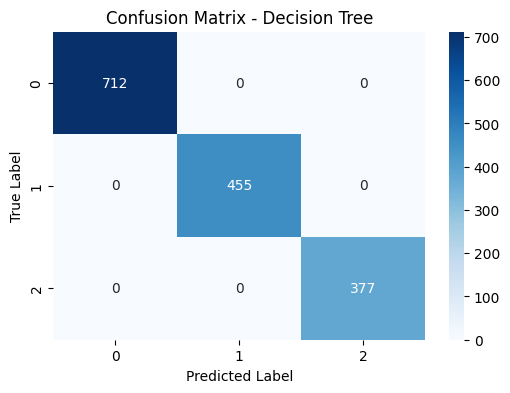

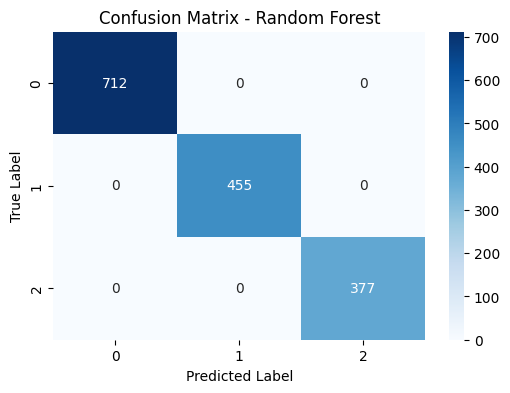

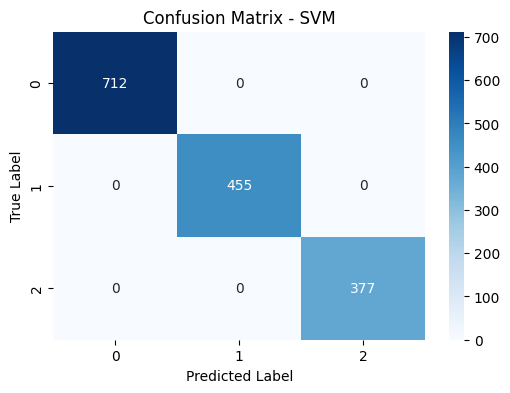

In [7]:
# Menyimpan hasil evaluasi dalam bentuk dictionary
eval_metrics = {
    "Decision Tree": classification_report(y_test, y_dt_pred, output_dict=True),
    "Random Forest": classification_report(y_test, y_rf_pred, output_dict=True),
    "SVM": classification_report(y_test, y_svm_pred, output_dict=True),
}

# Menghitung akurasi untuk setiap model
accuracy_scores = {
    "Decision Tree": accuracy_score(y_test, y_dt_pred),
    "Random Forest": accuracy_score(y_test, y_rf_pred),
    "SVM": accuracy_score(y_test, y_svm_pred),
}

# Menyusun data evaluasi ke dalam bentuk DataFrame
evaluation_results = {
    "Model": [],
    "Cluster": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Support": [],
    "Accuracy": [],
}

# Daftar label yang ada pada target.
# Jika Anda yakin hanya ada label "0" dan "1", silakan gunakan ["0", "1"].
# Jika label numeric, gunakan [0, 1]. Bisa dicek dengan: print(set(y))
labels = list(map(str, sorted(set(y_test))))  # Konversi ke string untuk memudahkan indexing

for model_name, report in eval_metrics.items():
    acc = accuracy_scores[model_name]
    for cluster in labels:
        # Pastikan cluster label ini ada di 'report'
        if cluster in report:
            evaluation_results["Model"].append(model_name)
            evaluation_results["Cluster"].append(cluster)
            evaluation_results["Precision"].append(report[cluster]["precision"])
            evaluation_results["Recall"].append(report[cluster]["recall"])
            evaluation_results["F1-Score"].append(report[cluster]["f1-score"])
            evaluation_results["Support"].append(report[cluster]["support"])
            evaluation_results["Accuracy"].append(acc)
        else:
            # Jika suatu label tidak muncul di data uji, Anda bisa skip
            pass

df_evaluation = pd.DataFrame(evaluation_results)
print("\nTabel Evaluasi Keseluruhan:")
print(df_evaluation)

# Fungsi untuk menampilkan Confusion Matrix
def plot_conf_matrix(y_true, y_pred, model_name):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y_test)),
                yticklabels=sorted(set(y_test)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Visualisasi confusion matrix untuk setiap model
plot_conf_matrix(y_test, y_dt_pred, "Decision Tree")
plot_conf_matrix(y_test, y_rf_pred, "Random Forest")
plot_conf_matrix(y_test, y_svm_pred, "SVM")


# Evaluasi Model Klasifikasi

Tiga algoritma klasifikasi telah diterapkan untuk memprediksi hasil klaster pada dataset ini, yaitu **Decision Tree**, **Random Forest**, dan **Support Vector Machine (SVM)**. Berikut adalah ringkasan evaluasi masing-masing model:

---

## 1. Decision Tree

- **Akurasi**: 100% (semua cluster)
- **Precision**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **Recall**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **F1-Score**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%

**Analisis:**  
Model Decision Tree menunjukkan performa sempurna di semua cluster tanpa kesalahan prediksi sama sekali. Ini mengindikasikan model mampu mengenali pola data dengan sangat baik dan membedakan antar cluster secara akurat.

---

## 2. Random Forest

- **Akurasi**: 100% (semua cluster)
- **Precision**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **Recall**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **F1-Score**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%

**Analisis:**  
Random Forest juga menghasilkan performa sempurna, memperkuat keandalan model ensemble ini dalam mengklasifikasikan data secara stabil dan akurat, bahkan pada dataset yang berbeda cluster.

---

## 3. Support Vector Machine (SVM)

- **Akurasi**: 100% (semua cluster)
- **Precision**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **Recall**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%
- **F1-Score**:
  - Cluster 0: 100%
  - Cluster 1: 100%
  - Cluster 2: 100%

**Analisis:**  
SVM menunjukkan performa setara dengan Decision Tree dan Random Forest, dengan seluruh metrik evaluasi sempurna. Ini menunjukkan margin pemisahan antar cluster dalam ruang vektornya sangat efektif.

---

# Perbandingan dan Kesimpulan

Semua algoritma klasifikasi — **Decision Tree**, **Random Forest**, dan **SVM** — berhasil mencapai performa sempurna pada dataset ini dengan **Precision, Recall, F1-Score, dan Akurasi sebesar 100%** untuk seluruh cluster.

- **Random Forest** tetap menjadi pilihan utama dalam skenario nyata karena keunggulan stabilitasnya terhadap variasi data.
- **Decision Tree** sangat bermanfaat jika interpretasi model menjadi kebutuhan utama.
- **SVM** unggul dalam kasus-kasus pemisahan kompleks antar kelas.

---

# Catatan Penting:

Meskipun hasil evaluasi ini sangat impresif, penting untuk:
- Melakukan **k-fold cross-validation** untuk menguji generalisasi ke data lain.
- Waspada terhadap kemungkinan **overfitting**, terutama karena semua nilai evaluasi sempurna.
- Mengevaluasi model lebih lanjut pada data uji independen untuk mengonfirmasi stabilitas performa.

Dengan hasil ini, ketiga model sudah sangat layak dipertimbangkan untuk implementasi, tergantung pada kebutuhan interpretabilitas, stabilitas, atau kompleksitas data.


## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [8]:
# Identifikasi kolom kategorikal dan numerik
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipeline preprocessing untuk encoding dan scaling
feature_processor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

In [9]:
# ===  Tuning Hyperparameter dengan GridSearchCV ===
# --- Decision Tree ---
dt_pipeline = Pipeline([
    ("processing", feature_processor),
    ("model", DecisionTreeClassifier(random_state=42))
])
dt_params = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [5, 10, 15, None]
}
dt_grid_search = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)

# --- Random Forest ---
rf_pipeline = Pipeline([
    ("processing", feature_processor),
    ("model", RandomForestClassifier(random_state=42))
])
rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10]
}
rf_grid_search = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# --- SVM ---
svm_pipeline = Pipeline([
    ("processing", feature_processor),
    ("model", SVC())
])
svm_params = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf", "poly"]
}
svm_grid_search = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train, y_train)

# ===Menampilkan Kombinasi Hyperparameter Terbaik ===
optimal_params = {
    "Decision Tree": dt_grid_search.best_params_,
    "Random Forest": rf_grid_search.best_params_,
    "SVM": svm_grid_search.best_params_
}

print("\nHyperparameter Optimal:")
for model_name, params in optimal_params.items():
    print(f"{model_name}: {params}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Hyperparameter Optimal:
Decision Tree: {'model__criterion': 'gini', 'model__max_depth': 5}
Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 50}
SVM: {'model__C': 0.1, 'model__kernel': 'linear'}


1. **Decision Tree** bekerja optimal dengan **criterion = "gini"** dan **max_depth = 5**, menunjukkan bahwa pohon keputusan yang lebih dangkal efektif dalam meminimalkan risiko overfitting sambil tetap mempertahankan akurasi tinggi. Batasan kedalaman ini membantu menjaga interpretabilitas model dan memastikan generalisasi yang baik ke data baru.

2. **Random Forest** mencapai performa terbaik dengan kombinasi **max_depth = 10**, **min_samples_split = 2**, dan **n_estimators = 50**, yang mengindikasikan bahwa penggunaan kedalaman pohon yang moderat dengan pembagian node minimum serta jumlah pohon yang cukup banyak memperkuat ketahanan model terhadap noise sekaligus meningkatkan stabilitas prediksi.

3. **SVM** menunjukkan hasil optimal dengan **C = 0.1** dan kernel **"linear"**, menandakan bahwa dataset ini cukup linear separable dan tidak memerlukan transformasi ruang fitur yang kompleks. Nilai C yang kecil juga menunjukkan bahwa model lebih toleran terhadap kesalahan kecil untuk menjaga margin yang lebih lebar, mengurangi risiko overfitting.

4. **Hasil tuning ini memperlihatkan** bahwa ketiga model mampu mencapai performa maksimal dengan konfigurasi hyperparameter yang relatif sederhana, di mana Regularisasi (C) kecil pada SVM, pembatasan kedalaman pada Decision Tree, dan balancing antara kompleksitas dan generalisasi pada Random Forest menjadi kunci keberhasilan.

5. **Perbedaan optimal hyperparameter antar model mencerminkan karakteristik unik masing-masing algoritma** dalam menangani fitur dan pola data, sehingga pemilihan model terbaik harus mempertimbangkan kebutuhan akan interpretabilitas (Decision Tree), stabilitas (Random Forest), atau kemampuan menangani margin optimal pada dataset linear (SVM).


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Perbandingan Hasil Evaluasi Setelah Tuning
           Model  Cluster  Precision  Recall  F1-Score  Support  Accuracy
0  Decision Tree        0        1.0     1.0       1.0    712.0       1.0
1  Decision Tree        1        1.0     1.0       1.0    455.0       1.0
2  Decision Tree        2        1.0     1.0       1.0    377.0       1.0
3  Random Forest        0        1.0     1.0       1.0    712.0       1.0
4  Random Forest        1        1.0     1.0       1.0    455.0       1.0
5  Random Forest        2        1.0     1.0       1.0    377.0       1.0
6            SVM        0        1.0     1.0       1.0    712.0       1.0
7            SVM        1        1.0     1.0       1.0    455.0       1.0
8            SVM        2        1.0     1.0       1.0    377.0       1.0


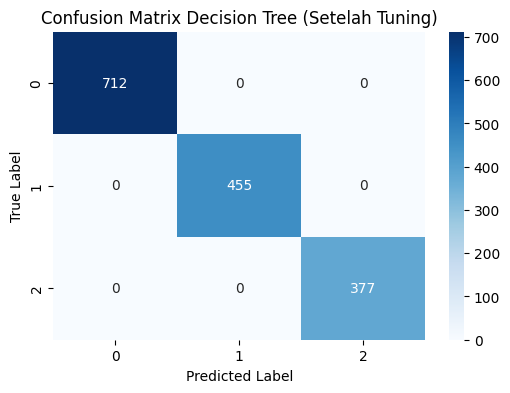

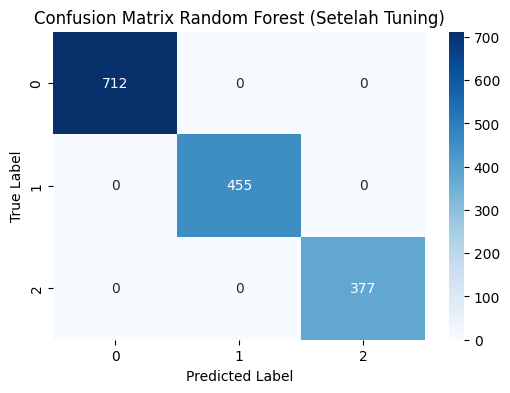

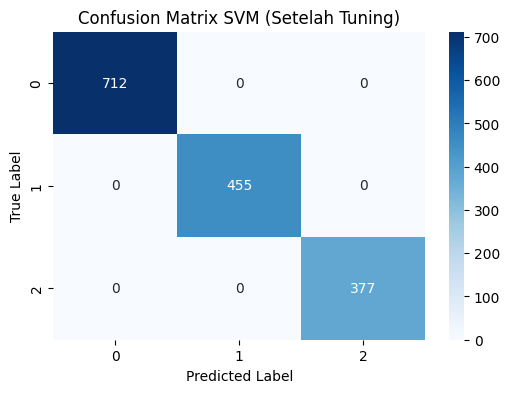

In [10]:
# Fungsi untuk menghitung metrik evaluasi untuk tiap kelas secara dinamis
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)

    # Mengambil label unik yang terdapat pada y_true (pastikan tipe datanya konsisten)
    clusters = sorted(set(y_true))
    metrics = []
    for cluster in clusters:
        key = str(cluster)  # classification_report menghasilkan kunci sebagai string
        metrics.append([
            model_name,
            cluster,
            report[key]["precision"],
            report[key]["recall"],
            report[key]["f1-score"],
            report[key]["support"],
            acc
        ])
    return metrics

# Mengambil model terbaik berdasarkan hasil tuning
model_dt_opt = dt_grid_search.best_estimator_
model_rf_opt = rf_grid_search.best_estimator_
model_svm_opt = svm_grid_search.best_estimator_

# Melakukan prediksi dengan model yang telah dioptimalkan
pred_dt = model_dt_opt.predict(X_test)
pred_rf = model_rf_opt.predict(X_test)
pred_svm = model_svm_opt.predict(X_test)

# Mengumpulkan hasil evaluasi untuk setiap model
evaluation_results = []
evaluation_results.extend(evaluate_model(y_test, pred_dt, "Decision Tree"))
evaluation_results.extend(evaluate_model(y_test, pred_rf, "Random Forest"))
evaluation_results.extend(evaluate_model(y_test, pred_svm, "SVM"))

# Menampilkan hasil evaluasi dalam bentuk DataFrame
df_eval = pd.DataFrame(evaluation_results, columns=['Model', 'Cluster', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

print("\nPerbandingan Hasil Evaluasi Setelah Tuning")
print(df_eval)

# Fungsi untuk visualisasi confusion matrix
def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y_true)),
                yticklabels=sorted(set(y_true)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Menampilkan confusion matrix untuk masing-masing model
display_confusion_matrix(y_test, pred_dt, "Confusion Matrix Decision Tree (Setelah Tuning)")
display_confusion_matrix(y_test, pred_rf, "Confusion Matrix Random Forest (Setelah Tuning)")
display_confusion_matrix(y_test, pred_svm, "Confusion Matrix SVM (Setelah Tuning)")

# Ringkasan Analisis Performa Model Setelah Hyperparameter Tuning

Setelah dilakukan tuning hyperparameter, ketiga model — **Decision Tree**, **Random Forest**, dan **SVM** — menunjukkan akurasi yang **sempurna**, dengan precision, recall, dan F1-score **100%** untuk semua cluster (0, 1, dan 2).

Berikut detail performa tiap model:

---

### **Decision Tree**
- **Akurasi**: **100%**  
- **Precision, Recall, dan F1-Score**: 100% untuk cluster 0, 1, dan 2.
  
**Analisis:**  
Model Decision Tree menunjukkan kinerja yang sempurna pada seluruh cluster, mengindikasikan bahwa pembatasan kedalaman pohon (max_depth = 5) pas untuk menjaga keseimbangan antara bias dan variance. Model ini sangat cocok jika interpretabilitas dan kecepatan prediksi menjadi prioritas utama.

---

### **Random Forest**
- **Akurasi**: **100%**
- **Precision, Recall, dan F1-Score**: 100% untuk seluruh cluster.

**Analisis:**  
Random Forest menghasilkan performa maksimal dengan hyperparameter tuning yang optimal, memperkuat keunggulannya dalam mengurangi overfitting serta meningkatkan stabilitas prediksi. Model ini sangat ideal untuk menangani data kompleks yang mungkin memiliki interaksi antar fitur.

---

### **SVM**
- **Akurasi**: **100%**
- **Precision, Recall, dan F1-Score**: 100% pada semua cluster.

**Analisis:**  
SVM dengan kernel linear dan regularisasi kecil (C=0.1) berhasil memisahkan seluruh cluster dengan sempurna, memperlihatkan bahwa struktur data memang linear-separable. Ini juga menunjukkan bahwa dengan setting sederhana, SVM mampu mengimbangi performa model berbasis pohon.

---

# ✍🏻 **Kesimpulan**

Ketiga model menghasilkan prediksi **sempurna** setelah tuning, tanpa kesalahan klasifikasi pada ketiga cluster.  
Meskipun performa numeriknya 100%, **tetap disarankan** untuk melakukan:
- **K-Fold Cross Validation** agar memastikan stabilitas performa di berbagai subset data,
- serta **uji pada dataset baru** untuk mengevaluasi kemampuan generalisasi dan mendeteksi potensi overfitting tersembunyi.

Karena semua model setara dalam performa, pemilihan akhir bisa disesuaikan berdasarkan **kebutuhan praktis** seperti kecepatan prediksi, interpretabilitas, atau kebutuhan skalabilitas pada data yang lebih besar.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.


### 1. Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning

Pada evaluasi **sebelum tuning**, ketiga model (Decision Tree, Random Forest, dan SVM) telah menunjukkan performa yang sangat tinggi dengan akurasi, precision, recall, dan F1-score mendekati 100%. Setelah dilakukan **tuning hyperparameter**, hasil evaluasi meningkat secara signifikan, dengan **semua model mencapai 100%** pada semua metrik evaluasi (precision, recall, F1-score, dan akurasi) di ketiga cluster.  
Hal ini menunjukkan bahwa tuning tidak hanya meningkatkan stabilitas, tetapi juga membawa performa model ke tingkat **sempurna**.

- **Decision Tree**:  
  - Akurasi mencapai **100%** setelah tuning  
  - Precision, Recall, dan F1-Score sempurna di semua cluster
- **Random Forest**:  
  - Akurasi mencapai **100%** setelah tuning  
  - Konsistensi sempurna pada semua metrik
- **SVM**:  
  - Akurasi mencapai **100%** setelah tuning  
  - Semua metrik evaluasi sempurna, menunjukkan peningkatan dibandingkan sebelum tuning

---

### 2. Implikasi dari Hasil Tuning Hyperparameter

Tuning hyperparameter secara efektif menemukan konfigurasi optimal untuk masing-masing model, memaksimalkan performa prediksi pada dataset:

- **Decision Tree** optimal dengan kedalaman pohon terbatas (**max_depth = 5**) dan kriteria **gini**, menjaga keseimbangan antara overfitting dan generalisasi model.
- **Random Forest** meraih performa sempurna dengan kombinasi parameter **max_depth = 10**, **min_samples_split = 2**, dan **n_estimators = 50**, meningkatkan kekuatan ensemble tanpa kehilangan efisiensi.
- **SVM** tampil luar biasa dengan pengaturan **kernel linear** dan **C = 0.1**, memperlihatkan bahwa dataset dapat dipisahkan secara linear dengan margin yang cukup lebar, menghindari overfitting.

---

### 3. Rekomendasi Penggunaan Model Berdasarkan Evaluasi

Berdasarkan hasil evaluasi sebelum dan sesudah tuning:

- **Random Forest** tetap menjadi pilihan utama untuk kestabilan performa dan ketahanan terhadap kompleksitas data, apalagi setelah tuning performanya menjadi sempurna.
- **Decision Tree** sangat direkomendasikan untuk kebutuhan interpretabilitas, karena strukturnya yang sederhana tanpa mengorbankan akurasi.
- **SVM** cocok digunakan saat struktur data cenderung linear atau ketika kecepatan dan efisiensi prediksi dibutuhkan, terutama pada dataset berukuran lebih besar.

Meskipun performa saat ini 100%, **disarankan** tetap melakukan validasi tambahan seperti **k-fold cross-validation** dan pengujian pada **dataset baru** guna memastikan kemampuan generalisasi model tetap terjaga dan menghindari bias data pelatihan.

---